# Explore the difference of methylation between cancer-normal

---

---



## <span class="label label-success"> Analysis </span>
- Heatmap of median in normal-average in cancer
- Cumulative distributions of differences
- Annotation bias among differentially methylated probes


---

## <span class="label label-warning">NOTE</span>
- Assymetric ditrubution of differences
- sqlite median from here : http://stackoverflow.com/questions/15763965/how-can-i-calculate-the-median-of-values-in-sqlite


---


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.style.use('ggplot')

import os
import subprocess
import time

import re

In [2]:
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/explore_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)
os.environ['TMPDIR']='/nagyvinyok/adat84/sotejedlik/ribli/tmp'

In [3]:
#sql exetcuter func
def run_sqlilte3(command,db,output=''):
    start=time.time()
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    try:
        print subprocess.check_output('/usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output,
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output
    
    subprocess.call(['rm','tempf.sql'])
    print 'It took',int(time.time()-start),'s'

In [10]:
#sql exetcuter func
def run_sqlilte3_slurm(command,db,output=''):
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    with open('tempf_sql.sh','w') as tempf:
        tempf.write('#!/bin/sh\n /usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output)
        
    try:
        print subprocess.check_output('sbatch -C jimgray84 tempf_sql.sh',
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output

---

### Calculate medians for probes amond all disease status


In [7]:
#create table with medians of beta amond a disease in every probe

run_sqlilte3_slurm('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

CREATE TABLE disease_median_beta AS 
    SELECT dm.disease AS disease,dm.probe AS probe, MEDIAN(beta) AS medb
    FROM (SELECT * 
        FROM meth AS m 
        INNER JOIN disease_annot AS d ON m.sample=d.sample) AS dm
    GROUP BY dm.disease,dm.probe;
    
CREATE INDEX probe_disease_index_dmb ON disease_median_beta(probe,disease,medb);
CREATE INDEX median_index_dmb ON disease_median_beta(medb,probe,disease);
    
''',db='../db/meth_db')

Submitted batch job 341192

It took 0 s


### Create heatmap of cancer, and normal-C medians

In [13]:
#create the heatmap
run_sqlilte3_slurm('''
.separator "\t"

SELECT ROUND((dmed1.medb)*100)*0.01 AS cancer_bin,
       ROUND((dmed2.medb)*100)*0.01 AS normal_bin, COUNT(*)
FROM disease_median_beta AS dmed1
INNER JOIN disease_median_beta AS dmed2 ON dmed1.probe=dmed2.probe 
    AND dmed1.disease='cancer' AND dmed2.disease='normal-C'
GROUP BY ROUND((dmed1.medb)*100)*0.01,
       ROUND((dmed2.medb)*100)*0.01;

''',db='../db/meth_db',output='norm_canc_med_heatmap.csv')

Submitted batch job 341195



### Load and plot heatmap

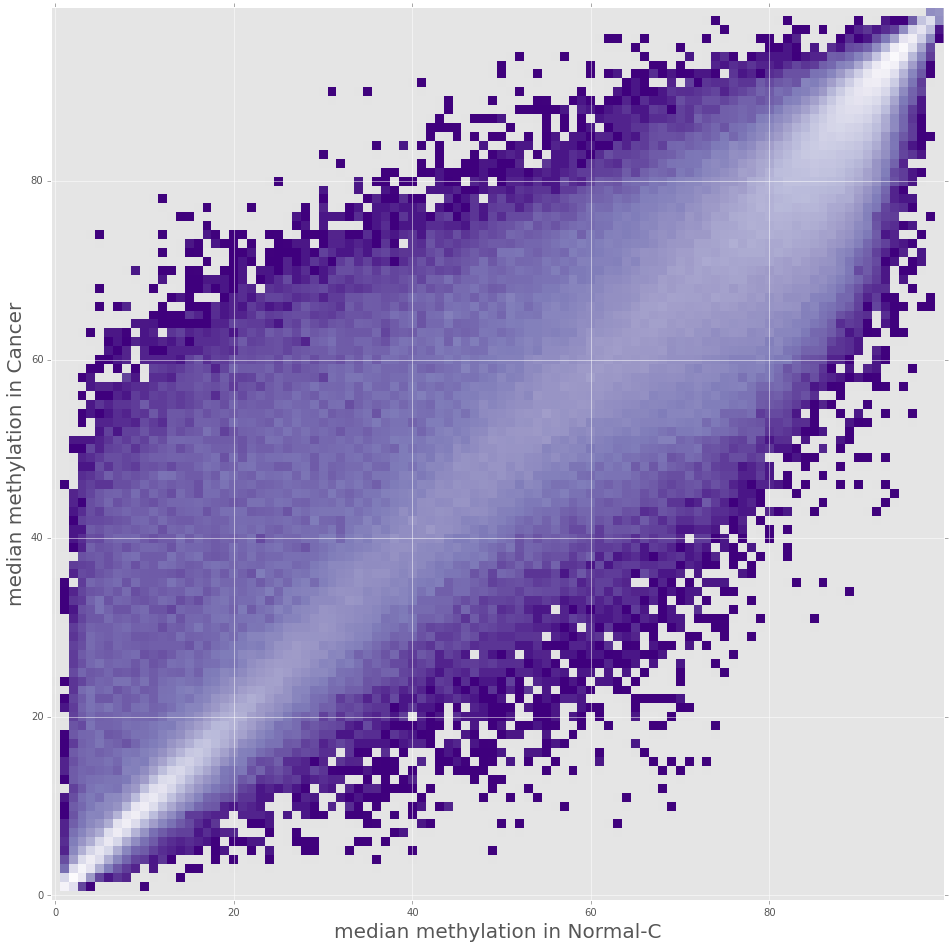

In [38]:
# load the heatmap
my_heatmap=np.zeros([100,100])
f=open('norm_canc_med_heatmap.csv')
for line in f:
    line_list=line.split('\t')
    canc_bin=int(np.round(100*float(line_list[0])))
    norm_bin=int(np.round(100*float(line_list[1])))
    count=int(line_list[2])
    my_heatmap[canc_bin,norm_bin]+=count
f.close()

#plot it
from matplotlib.colors import LogNorm
fig,ax=plt.subplots()
fig.set_size_inches(16,16)
ax.imshow(my_heatmap,interpolation='none',origin='lower', 
          norm=LogNorm(),cmap=plt.cm.Purples_r)
ax.set_xlabel('median methylation in Normal-C',fontsize=20)
dump=ax.set_ylabel('median methylation in Cancer',fontsize=20)

### See some probes

In [22]:
run_sqlilte3_slurm('''
.separator "\t"

CREATE TABLE meth_median_diff AS 
    SELECT dmed1.probe AS probe , dmed1.medb - dmed2.medb AS mdiff
    FROM disease_median_beta AS dmed1
    INNER JOIN disease_median_beta AS dmed2 ON dmed1.probe=dmed2.probe 
        AND dmed1.disease='cancer' AND dmed2.disease='normal-C';
    
CREATE INDEX diff_index_mmd ON meth_median_diff(mdiff,probe);
CREATE INDEX probe_index_mmd ON meth_median_diff(probe,mdiff);
    
''',db='../db/meth_db')

Submitted batch job 341197



In [56]:
run_sqlilte3_slurm('''
.separator "\t"

WITH hypermeth_probes AS(
    SELECT probe
    FROM meth_median_diff
    ORDER by -mdiff
    LIMIT 100)

SELECT hm.probe, hm.beta, dann.disease 
FROM (
    SELECT m.probe,m.beta,m.sample
    FROM hypermeth_probes as h
    INNER JOIN meth as m ON h.probe=m.probe) AS hm
INNER JOIN disease_annot AS dann ON dann.sample=hm.sample;

''',db='../db/meth_db',output='hypermeth_probes.csv')

Submitted batch job 341201



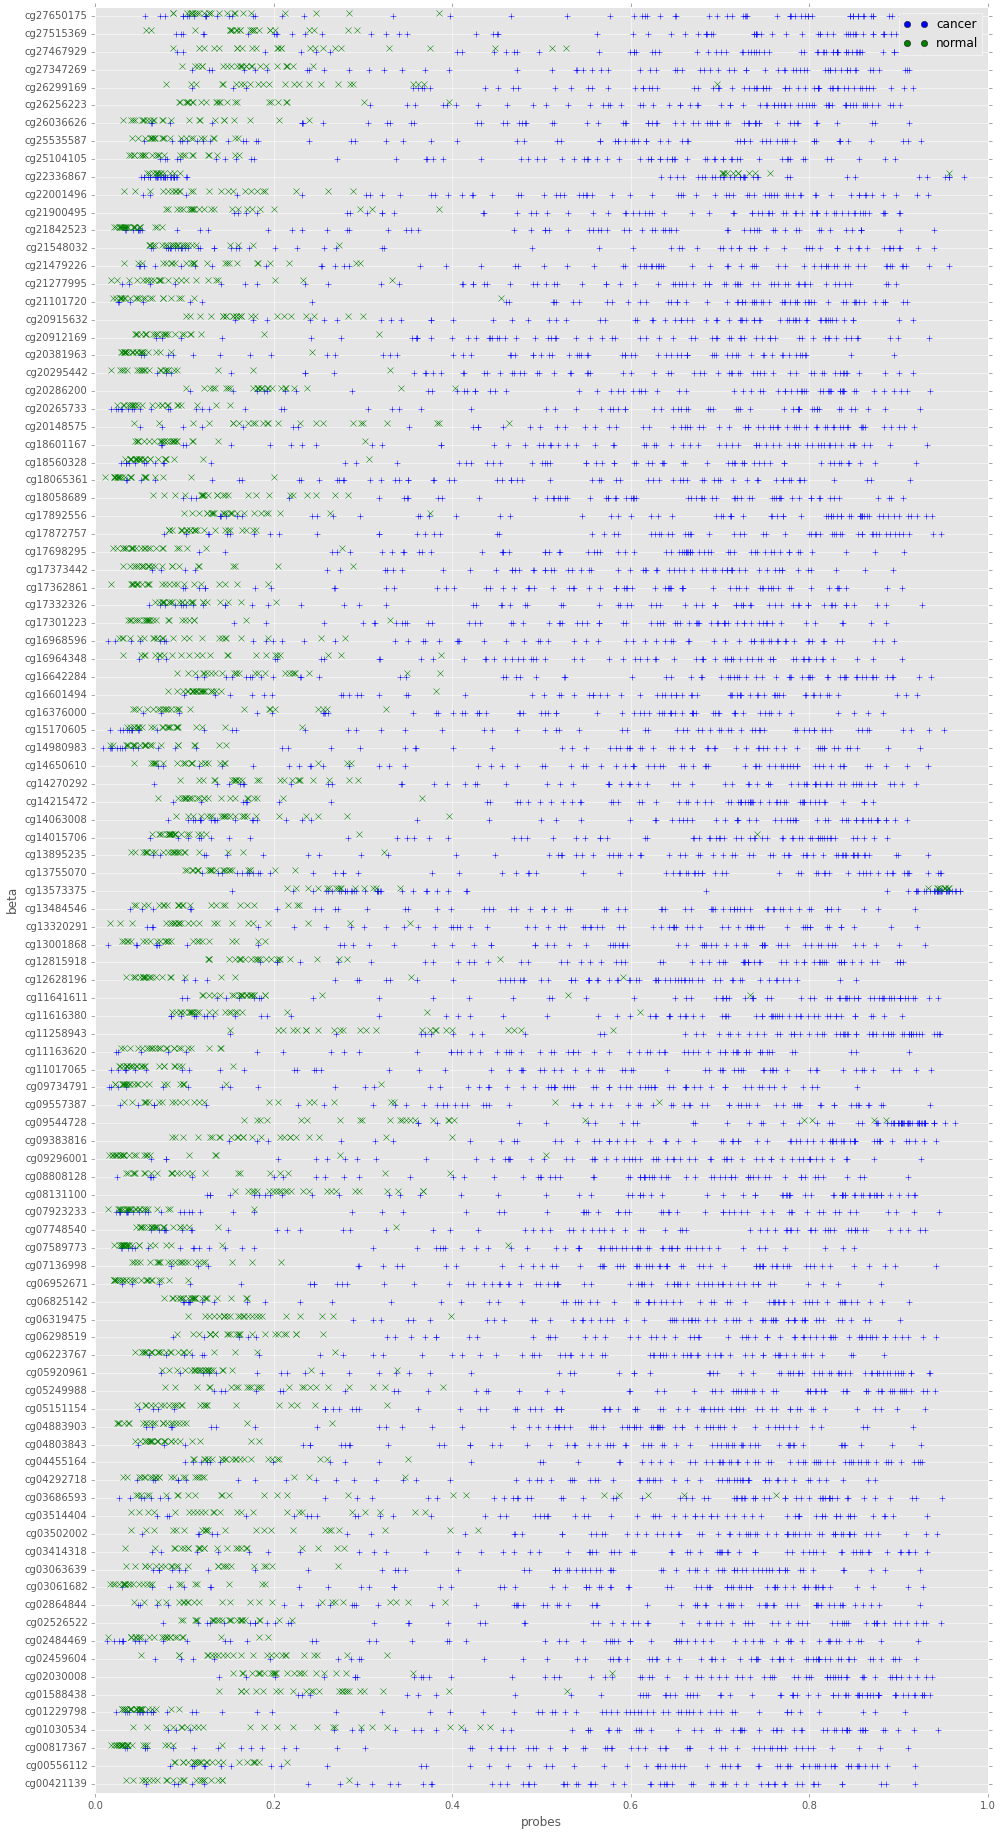

In [58]:
hyp_probes=pd.read_csv('hypermeth_probes.csv',header=None,sep='\t',
                     names=['probe','beta','disease'])

probes=np.unique(hyp_probes['probe'])

fig,ax=plt.subplots()
fig.set_size_inches(16,32)

cancer_idx=hyp_probes['disease']=='cancer'
normal_idx=hyp_probes['disease']=='normal-C'
i=0
for probe in probes:
    probe_idx=hyp_probes['probe']==probe
    
    xc=hyp_probes[probe_idx & cancer_idx]['beta']
    yc=i*np.ones(len(xc))
    xn=hyp_probes[probe_idx & normal_idx]['beta']
    yn=i*np.ones(len(xn))+0.2
    
    ax.plot(xc,yc,'+',c='b',lw=3)
    ax.plot(xn,yn,'x',c='g',lw=3)
                               
    i+=1
    
ax.set_yticks(range(len(probes)))
ax.set_yticklabels(probes,rotation='horizontal')

ax.set_ylim(-.5,len(probes)-.5)
    
ax.plot([],[],'o',c='b',label='cancer')
ax.plot([],[],'o',c='g',label='normal')

ax.legend()
ax.set_xlabel('probes')
ax.set_ylabel('beta')

In [60]:
run_sqlilte3_slurm('''
.separator "\t"

SELECT mdiff
FROM meth_median_diff
ORDER by -mdiff;

''',db='../db/meth_db',output='med_diffmet_all.csv')

Submitted batch job 341202



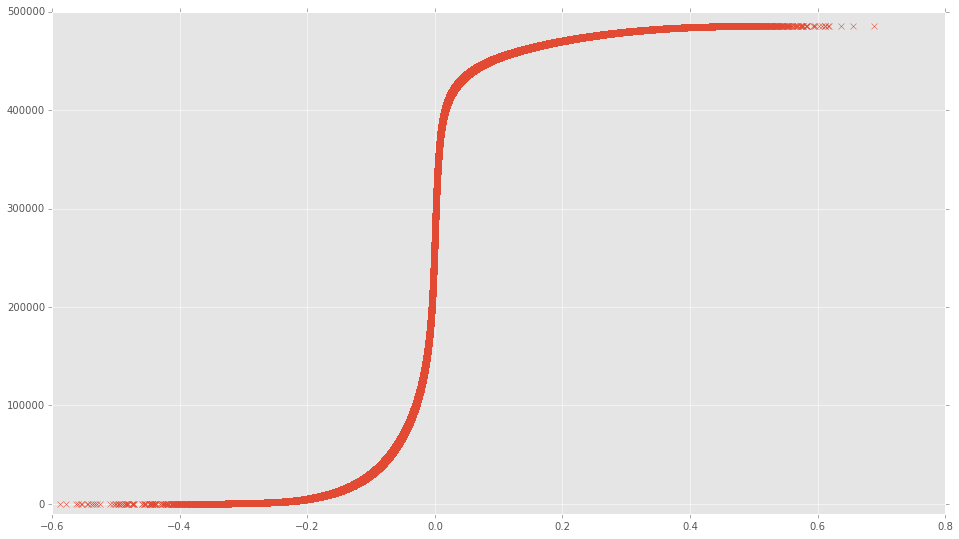

In [67]:
mdiff_all=pd.read_csv('med_diffmet_all.csv',header=None,sep='\t',names=['mdiff'])
fig,ax=plt.subplots()
fig.set_size_inches(16,9)

ax.plot(mdiff_all['mdiff'],len(mdiff_all)-np.arange(len(mdiff_all)),'x')
dump=ax.set_ylim(-1e4,5e5)

----

## Annotation bias of the differentially methylated probes

### CpG islands are 10x more likely to be differentially methylated than the 'ocean'

In [91]:
run_sqlilte3_slurm('''
.separator "\t"
    
SELECT n.Relation_to_UCSC_CpG_Island,COUNT(*)
FROM ncbi_450_annot AS n
GROUP BY n.Relation_to_UCSC_CpG_Island;

''',db='../db/meth_db',output='tmp_out.csv')

Submitted batch job 341211



In [92]:
%%bash
cat tmp_out.csv

	176047
Island	150254
N_Shelf	24844
N_Shore	62870
S_Shelf	22300
S_Shore	49197


In [112]:
run_sqlilte3_slurm('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH temp_table AS (
    SELECT probe
    FROM meth_median_diff
    WHERE abs(mdiff)>0.3)
    
SELECT n.Relation_to_UCSC_CpG_Island,COUNT(*)
FROM ncbi_450_annot AS n
INNER JOIN temp_table AS m ON m.probe=n.IlmnID
GROUP BY n.Relation_to_UCSC_CpG_Island;

''',db='../db/meth_db',output='tmp_out.csv')

Submitted batch job 341219



In [114]:
%%bash
cat tmp_out.csv

	654
Island	5238
N_Shelf	43
N_Shore	503
S_Shelf	47
S_Shore	333


### The promoter associated probes are not more likely to be diffmet

In [98]:
run_sqlilte3_slurm('''
.separator "\t"
    
SELECT n.Regulatory_Feature_Group,COUNT(*)
FROM ncbi_450_annot AS n
GROUP BY n.Regulatory_Feature_Group;

''',db='../db/meth_db',output='tmp_out.csv')

Submitted batch job 341214



In [99]:
%%bash
cat tmp_out.csv

	315420
Gene_Associated	1288
Gene_Associated_Cell_type_specific	1963
NonGene_Associated	1339
NonGene_Associated_Cell_type_specific	220
Promoter_Associated	91963
Promoter_Associated_Cell_type_specific	6127
Unclassified	30461
Unclassified_Cell_type_specific	36731


In [100]:
run_sqlilte3_slurm('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH temp_table AS (
    SELECT probe
    FROM meth_median_diff
    WHERE abs(mdiff)>0.3)
    
SELECT n.Regulatory_Feature_Group,COUNT(*)
FROM ncbi_450_annot AS n
INNER JOIN temp_table AS m ON m.probe=n.IlmnID
GROUP BY n.Regulatory_Feature_Group;

''',db='../db/meth_db',output='tmp_out.csv')

Submitted batch job 341215



In [103]:
%%bash
cat tmp_out.csv

	4251
Gene_Associated	5
Gene_Associated_Cell_type_specific	16
NonGene_Associated	7
NonGene_Associated_Cell_type_specific	7
Promoter_Associated	526
Promoter_Associated_Cell_type_specific	81
Unclassified	612
Unclassified_Cell_type_specific	1313
